## Loading a sub-01 test run:

In [3]:
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [25]:
data = nib.load("sub-01_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz").get_fdata()
atlas = nib.load('sleep_data\Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_2mm.nii.gz')

atlas_data = atlas.get_fdata()
atlas_data = np.round(atlas_data)
atlas_labels = np.unique(atlas_data)
atlas_labels = atlas_labels[1:] # remove 0
atlas_labels = atlas_labels.astype(int)

data.shape, atlas_data.shape, atlas_labels.shape

((97, 115, 97, 286), (97, 115, 97), (116,))

### Defining regions in the data with the Schaefer2018 100Parcels atlas combined with the Tian Subcortex 16Parcels atlas:

In [ ]:
import os

if not os.path.exists('data_regions.csv'):
    data_region = np.zeros((data.shape[3], len(atlas_labels)))
    for j in tqdm(range(len(atlas_labels))):
        for k in range(data.shape[3]):
            data_region[k,j] = np.mean(data[:,:,:,k][atlas_data == atlas_labels[j]])

    df = pd.DataFrame(data_region)
    df.to_csv('data_regions.csv', index=False)
else:
    df = pd.read_csv('data_regions.csv')
    data_region = df.values

data_region.shape

(286, 116)

KeyboardInterrupt: 

### Animating snapshots over time of a slice (idx=21):

In [ ]:
# def animate_snapshots(idx, data, fps=30, nSeconds=5):
#     from matplotlib.animation import FuncAnimation
    
#     # First set up the figure, the axis, and the plot element we want to animate
#     fig = plt.figure( figsize=(8,8) )
#     snapshots = data[:,:,idx,:]
#     a = snapshots[..., 0]
#     im = plt.imshow(a)

#     def animate_func(i):
#         if i % fps == 0:
#             print( '.', end ='' )
#         im.set_array(snapshots[..., i])
#         return [im]

#     anim = FuncAnimation(fig, animate_func, frames = nSeconds * fps, interval = 1000 / fps)
#     anim.save(f'time-varying-fmri-signal-i_{idx}.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

# animate_snapshots(idx=21, data=data)

### Filtering the signals with a bandpass filter:

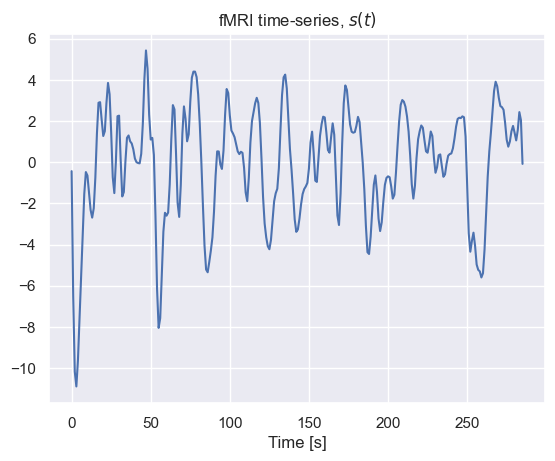

In [ ]:
from scipy.signal import butter, filtfilt, hilbert
import matplotlib.pyplot as plt
from seaborn import set_theme
set_theme()

normalized = lambda x: x / np.sum(x)

nyquist = 0.5 * 1/2.1 # code from "proc_data.py"
low = 0.008 / nyquist
high = 0.09 / nyquist
b, a = butter(2, [low, high], btype='band')

data_filtered = np.zeros_like(data_region)
for j in range(116):
    data_filtered[:,j] = filtfilt(b, a, data_region[:,j])

s_series = data_filtered

# plt.plot(data_region[:,0])
plt.plot(s_series[:,0])
plt.title("fMRI time-series, $s(t)$")
plt.xlabel('Time [s]');

## LEiDA

### Computing the Hilbert transform and the phase of the filtered signals:

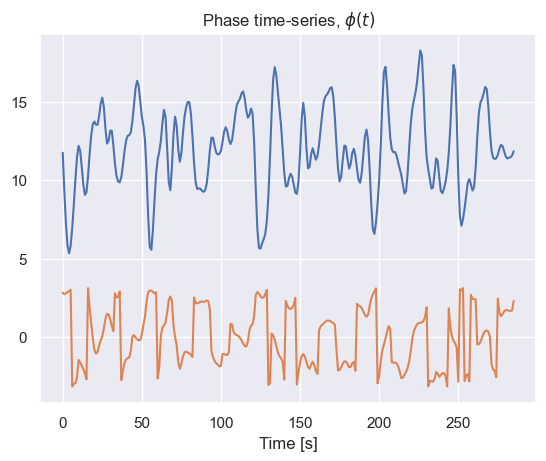

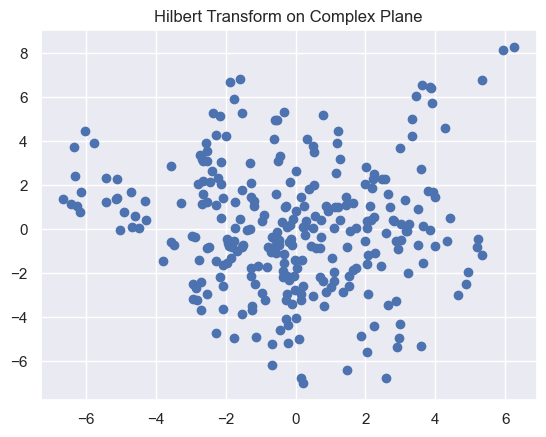

In [ ]:
def angle(x): return np.arctan(np.imag(x) / np.real(x))

hilbert_complex = hilbert(s_series)
phi_series = np.angle(hilbert_complex)

i = 50
plt.plot(s_series[:,i]+12)
plt.plot(phi_series[:,i])
plt.title("Phase time-series, $\phi(t)$")
plt.xlabel('Time [s]');
plt.show()

plt.scatter(np.real(hilbert_complex[:,i]), np.imag(hilbert_complex[:,i]));
plt.title("Hilbert Transform on Complex Plane");

### Computing the instantaneous coherence matrix from the phase:

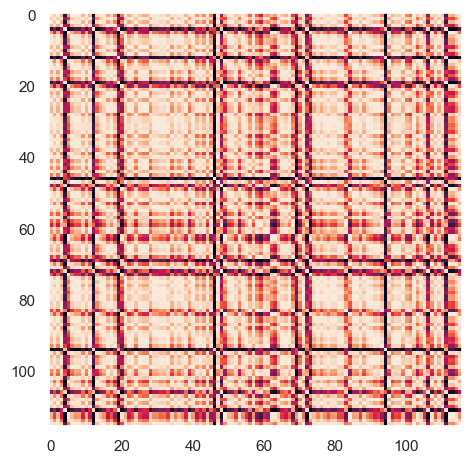

In [ ]:
# phi_mesh = np.meshgrid(phi_series, phi_series)
# A = np.cos(phi_mesh[0] - phi_mesh[1]) # phi_tj - phi_tk
coh_map = lambda x: np.outer(np.cos(x), np.cos(x)) + np.outer(np.sin(x), np.sin(x))

A = coh_map(phi_series[0])
# dont include gridlines:
plt.imshow(A)
plt.grid(False)
plt.tight_layout()

### Computing the eigenvectors of the instantaneous coherence matrix:

Explained Variance
v1: 48.54%	 v2: 51.46%


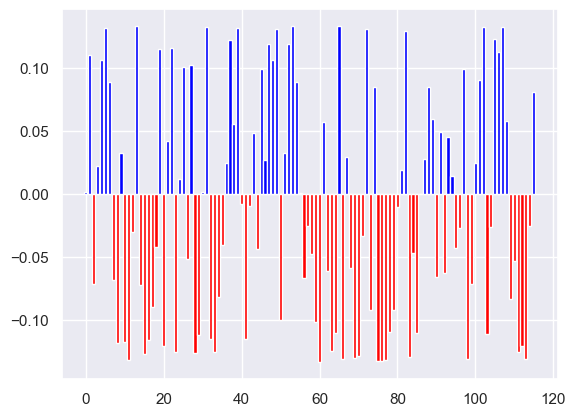

In [ ]:
eigval, eigvec = np.linalg.eigh(coh_map(phi_series[100]))
l, v1, v2 = eigval[-2:], eigvec[:,-2:][:,0], eigvec[:,-2:][:,1]

# explained variance as percentage:
print(f"Explained Variance\nv1: {normalized(l)[0]:.2%}\t v2: {normalized(l)[1]:.2%}")

plt.bar(range(len(v1)), v1, color=["red" if v < 0 else "blue" for v in v1]);
# red if under zero, blue if over zero

# Clustering

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from clustering import clustering
from importlib import reload

K = 2; p = 3; N = 50
clustering(K=K, p=p, N=N)
labels_df = np.load(f'clustering_labels_N{N}.npy')
# centroids_df = np.load(f'centroids_N{N}.npy', allow_pickle=True)

## NMI for comparisons

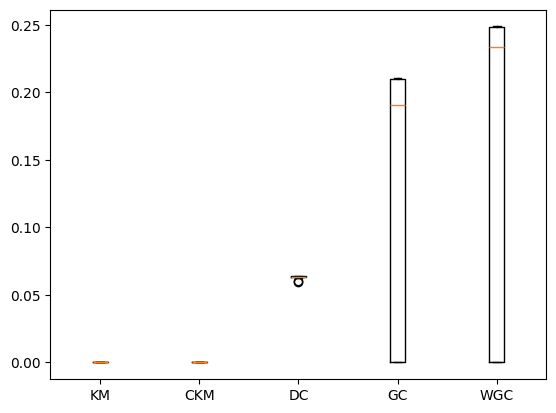

In [18]:
from NMI import *

true_labels = []
for i in range(K): true_labels += [i]*(labels_df.shape[2]//K)

NMI_df = np.zeros((labels_df.shape[0], labels_df.shape[1]))
for i in range(labels_df.shape[0]):
    for j in range(labels_df.shape[1]):
        NMI_df[i,j] = calc_NMI(labels_df[i,j], true_labels)
NMI_df# = NMI_df.T

for i in range(len(NMI_df)):
    plt.boxplot(NMI_df[i], positions=[i])
plt.xticks([0,1,2,3,4], ["KM", "CKM", "DC", "GC", "WGC"])
plt.show()

In [6]:
synth_data = np.loadtxt('synthetic_isotropic/synth_data_MACG_p'+str(p)+'K'+str(K)+'_1.csv',delimiter=',')
n = synth_data.shape[0]

data_gr = np.zeros((int(n/2),p,2))
data_gr[:,:,0] = synth_data[np.arange(n,step=2),:] # first frame
data_gr[:,:,1] = synth_data[np.arange(n,step=2)+1,:] # second frame
data_sphere = data_gr[:,:,0]

# def dist_func(x,y): return np.arccos(np.dot(x, y))
# from sklearn.cluster import KMeans
# model = KMeans(n_clusters=2).fit(data_sphere)
# model.

In [7]:
cov = centroids_df[0][3][0]
def centroid_from_covariance(covariance_matrix):
    """
    Find the 3D coordinates of the centroid from a covariance matrix.

    Parameters:
        covariance_matrix (np.ndarray): Covariance matrix.

    Returns:
        np.ndarray: 3D coordinates of the centroid.
    """
    # Compute eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Find the index of the maximum eigenvalue
    max_index = np.argmax(eigenvalues)

    # Scale the eigenvectors by the square root of their corresponding eigenvalues
    scaled_eigenvectors = np.sqrt(eigenvalues[max_index]) * eigenvectors[:, max_index]

    # Compute the centroid coordinates
    centroid = np.mean(scaled_eigenvectors, axis=0)

    return centroid

centroid_from_covariance(cov)

LinAlgError: Last 2 dimensions of the array must be square

In [21]:
centroids_df[-1][-1]

array([[[-0.6382585 ,  0.69527634],
        [ 0.62029011,  0.7187284 ],
        [ 0.45592354, -0.00450531]],

       [[-0.60444398,  0.6902871 ],
        [ 0.55456754,  0.7229739 ],
        [-0.5719286 , -0.0285036 ]]])

In [23]:
import plotly.express as px
px.defaults.color_continuous_scale = px.colors.sequential.Blackbody
fig = px.scatter_3d(x=data_sphere[:,0], y=data_sphere[:,1], z=data_sphere[:,2], color=labels_df[2][2], opacity=0.5)
fig.update_traces(marker_size = 2)

# centroids_df[0][3].T
fig.add_scatter3d(x=centroids_df[0,2][:,0], y=centroids_df[0,2][:,1], z=centroids_df[0,2].T[:,2], mode='markers', marker=dict(size=8, color='red'))